<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module3/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGBoost for Regression**
XGBoost is a powerful gradient boosting algorithm used for regression tasks, where the goal is to predict a continuous target variable based on one or more input features. It builds decision trees in a sequential manner, optimizing residual errors at each step. One of XGBoost’s strengths is its ability to **model complex nonlinear relationships** without extensive feature engineering. Additionally, **regularization** helps prevent overfitting compared to traditional regression models.

---

## **Steps of XGBoost Regression**

### **Step 1: Initialize Predictions**
- Set the initial prediction $f_0$ **equal to 0.5** or as the **mean** of target values \( Y \):
  $$
  f_0 = \frac{1}{n} \sum_{i=1}^{n} Y_i
  $$

---

### **Step 2: Compute Similarity Score for the Root Node**
- The **Similarity Score** determines how good a split is:
  $$
  \text{Similarity Score} = \frac{(\sum \text{Residuals})^2}{\text{Number of Residuals} + \lambda}
  $$
  where:
  - $\sum \text{Residuals}$ is the sum of residuals:  
    $$
    \sum \text{Residuals} = \sum (Y - f_0)
    $$
  - $ \text{Number of Residuals} $ is the number of samples.
  - $\lambda$ is the **regularization parameter** to control overfitting.

---

### **Step 3: Determine the Best Split**
- The model checks multiple **split conditions** at the root.
- The simplest method is to take the **mean** of two adjacent feature values.
- Compute the **Similarity Score** for the **left and right child nodes**.

---

### **Step 4: Compute Gain for Each Split and Choose the Best One**
- The Gain determines how much improvement the split provides:
  $$
  \text{Gain} = \text{Left Similarity Score} + \text{Right Similarity Score} - \text{Root Similarity Score}
  $$
- The split with the **highest Gain** is selected.

---

### **Step 5: Compute Output Value for Leaf Nodes**
- If the tree is deep enough, leaf nodes are assigned an **Output Value**:
  $$
  \text{Output} = \frac{\sum \text{Residuals}}{\text{Number of Residuals}}
  $$
- Here:
  - $ \sum \text{Residuals} $ is the sum of all residuals in the leaf node.
  - $ \text{Number of Residuals} $ is the number of samples in the leaf node.

---

### **Step 6: Update Predictions**
- Update the model prediction using:
  $$
  f_{t+1} = f_t + \eta \times \text{Output}
  $$
  where $\eta$ is the **learning rate**.

- Repeat **Step 2 to Step 5** until a stopping criterion is met (e.g., tree depth limit, early stopping).



##Example

Given the data

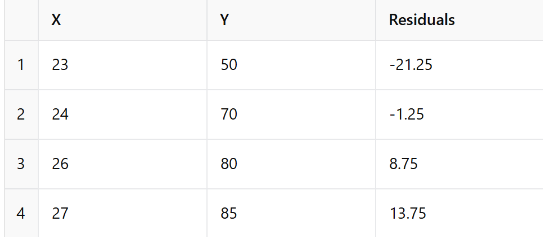


and $\lambda$ = 0, depth = 1, lr = 0.3

* $f_0$ = 71.25
* Residuals (see above)
* Root similarity = $(-21.25 -1.25 + 8.75 + 13.75)^2 / (4 + 0) = 0$
* For each case:

  1.   $X < 23.5$
  - Left Similarity = 451.56
  - Right Similarity = 150.52
  - Gain = Left + Right - Root = 602.08
  2.   $X < 25$
  - Left Similarity = 253.125
  - Right Similarity = 253.125
  - Gain = 506.25
  3.   $X < 26.5$
  - Left Similarity = 63.02
  - Right Similarity = 189.06
  - Gain = 252.08

- Thus, we will choose $X < 23.5$ as the condition to split the root. The left node is $-21.25$ and the right node is $7.08$
- When $x = 25$, the predicted value is $71.25 + 0.3*7.08 = 73.374$



##Code

In [1]:
!pip install --upgrade xgboost


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

###Process data

In [3]:
df = pd.read_csv('Problem3.csv')

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,4.468204,26.2,94.3,1.808289,8.2,51,6.7,False,0.0
1,7,4,oct,tue,4.517431,35.4,669.1,2.041220,18.0,33,0.9,False,0.0
2,7,4,oct,sat,4.517431,43.7,686.9,2.041220,14.6,33,1.3,False,0.0
3,8,6,mar,fri,4.529368,33.3,77.5,2.302585,8.3,97,4.0,True,0.0
4,8,6,mar,sun,4.503137,51.3,102.2,2.360854,11.4,99,1.8,False,0.0


Encode the data

In [4]:
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

ordinal_encoder = OrdinalEncoder()
encoded_df = df.copy()
encoded_df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols])

encoded_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,7.0,0.0,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0.0,0.0
1,7,4,10.0,5.0,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0.0,0.0
2,7,4,10.0,2.0,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0.0,0.0
3,8,6,7.0,0.0,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1.0,0.0
4,8,6,7.0,3.0,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0.0,0.0


Split the data

In [5]:
X = encoded_df.drop(columns = ['area'])
Y = encoded_df['area']

X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,7.0,0.0,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0.0
1,7,4,10.0,5.0,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0.0
2,7,4,10.0,2.0,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0.0
3,8,6,7.0,0.0,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1.0
4,8,6,7.0,3.0,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0.0


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.3,
                                                    random_state=7)

###Train model

In [7]:
xg_reg = xgb.XGBRegressor(seed = 7, learning_rate = 0.01,
                          n_estimators = 102,
                          max_depth = 3)
xg_reg.fit(X_train , Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
preds = xg_reg.predict (X_test)

mae = mean_absolute_error(Y_test , preds )
mse = mean_squared_error(Y_test , preds )

print("MAE: %f" % (mae))
print("MSE: %f" % (mse))


MAE: 1.148440
MSE: 1.884507


# **XGBoost for Classification**
XGBoost for classification is used to predict discrete class labels based on input features. It follows a boosting approach, sequentially refining weak learners to improve accuracy. Instead of predicting direct class labels, XGBoost **outputs probabilities**, which are converted into class predictions based on a threshold (usually 0.5).

---

## **Steps of XGBoost Classification**

### **Step 1: Initialize Predictions**
- The initial prediction \( f_0 \) is set to **0.5** (since class probabilities start at 50% confidence):
  $$
  f_0 = 0.5
  $$

---

### **Step 2: Compute Similarity Score for the Root Node**
- The **Similarity Score** measures the purity of a node:
  $$
  \text{Similarity Score} = \frac{(\sum \text{Residuals})^2}{\sum [\text{PreviousProbability} \times (1 - \text{PreviousProbability})] + \lambda}
  $$
  where:
  - $ \sum \text{Residuals} $ is the sum of differences between true values and predicted probabilities.
  - **PreviousProbability** is the probability from the last iteration (initially set to 0.5).
  - $ \lambda$ is the **regularization parameter**.

---

### **Step 3: Determine the Best Split**
- Different split conditions are tested to find the **best threshold**.
- The simplest method is to take the **mean** of two adjacent feature values.

---

### **Step 4: Compute Gain for Each Split and Choose the Best One**
- The Gain determines the effectiveness of a split:
  $$
  \text{Gain} = \text{Left Similarity Score} + \text{Right Similarity Score} - \text{Root Similarity Score}
  $$
- The split with the **highest Gain** is selected.

---

### **Step 5: Compute Output Value for Each Node**
- If a split is chosen, each node (left and right) receives an **Output Value**:
  $$
  \text{Output} = \frac{\sum \text{Residuals}}{\sum [\text{PreviousProbability} \times (1 - \text{PreviousProbability})]}
  $$
- Here:
  - $ \sum \text{Residuals} $ is the sum of all residuals in the node.
  - **PreviousProbability** is the probability prediction from the previous iteration.

---

### **Step 6: Update Predictions and Compute Class Probabilities**
- Update the **Log Odds** (Log Prediction) using:
  $$
  \log(\text{Prediction}) = \log \left( \frac{\text{PreviousProbability}}{1 - \text{PreviousProbability}} \right) + \eta \times \text{Output}
  $$
  where $ \eta $ is the **learning rate**.

- Convert log odds to **probability**:
  $$
  \text{Probability} = \frac{e^{\log(\text{Prediction})}}{1 + e^{\log(\text{Prediction})}}
  $$

---


##Example

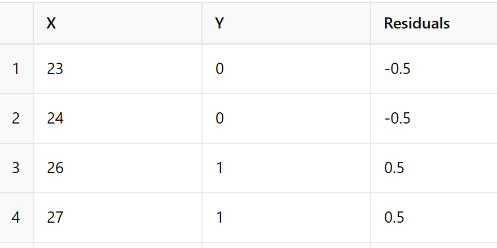

with $\lambda$ = 0, depth = 1, lr = 0.3

* $f_0$ = 0.5
* Residuals shown above
* Root similarity = $(-0.5 - 0.5 + 0.5 + 0.5)^2/(4*0.5*0.5 + 0) = 0$
* For each case:

  1.   $X < 23.5$
  - Left Similarity = 1
  - Right Similarity = 0.33
  - Gain = Left + Right - Root = 1.33
  2.   $X < 25$
  - Left Similarity = 2
  - Right Similarity = 2
  - Gain = 4
  3.   $X < 26.5$
  - Left Similarity = 0.33
  - Right Similarity = 1
  - Gain = 1.33

* Thus, the split condition is $X < 25$, with the left node equal to $-2$, and the right node equal to $2$
* When $x = 25$,
$$
\log(\text{Prediction}) = \log \left( \frac{\text{0.5}}{1 - \text{0.5}} \right) + 0.3 \times \text{2} = 0.6
$$

- Convert log odds to **probability**:
  $$
  \text{Probability} = \frac{e^{0.6}}{1 + e^{0.6}} = 0.6457
  $$
- Thus, it is classified as **True**




##Code

In [9]:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

###Process data

In [10]:
df = pd.read_csv('Problem4.csv')

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [11]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

###Train model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=7)

In [13]:
xg_class = xgb.XGBClassifier(seed = 7)

xg_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
preds = xg_class . predict ( X_test )

In [15]:
train_acc = accuracy_score(y_train, xg_class.predict(X_train))
test_acc = accuracy_score(y_test, preds)

print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Train accuracy: 1.0
Test accuracy: 0.9629629629629629


#Time Series Classification với XGBoost

In [16]:
import pandas as pd
import numpy as np
import matplotlib . pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

##Process data

In [21]:
!wget https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TRAIN.tsv # Download FordA_TRAIN.tsv
!wget https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TEST.tsv # Download FordA_TEST.tsv

--2025-01-30 10:10:28--  https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TRAIN.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20094049 (19M) [text/plain]
Saving to: ‘FordA_TRAIN.tsv’

FordA_TRAIN.tsv     100%[===================>]  19.16M  90.6MB/s    in 0.2s    

2025-01-30 10:10:29 (90.6 MB/s) - ‘FordA_TRAIN.tsv’ saved [20094049/20094049]

--2025-01-30 10:10:29--  https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TEST.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7364408 (7.

In [22]:
def readucr(filename) :
  data = np.loadtxt(filename, delimiter ="\t")
  y = data [:, 0]
  x = data [:, 1:]
  return x, y.astype(int)

x_train, y_train = readucr("FordA_TRAIN.tsv")
x_test, y_test = readucr("FordA_TEST.tsv")

Visualize data

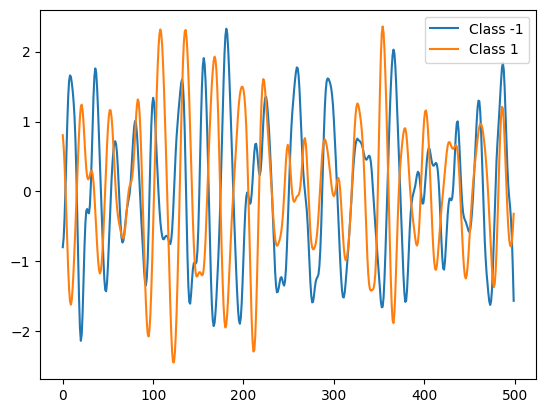

In [23]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()

for c in classes :
  c_x_train = x_train[y_train == c]
  plt.plot(c_x_train[0], label="Class " + str(c))

plt.legend(loc = "best")
plt.show()
plt.close()

In [24]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

##Train model

In [25]:
model = XGBClassifier(n_estimators =200, random_state =42)
model.fit (x_train , y_train )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [27]:
y_pred = model.predict(x_test)

print (" Confusion Matrix :")
print ( confusion_matrix ( y_test , y_pred ) )

print (" Classification Report :")
print ( classification_report ( y_test , y_pred ) )

accuracy = accuracy_score ( y_test , y_pred )
print ( f" Accuracy : { accuracy :.2f}")

 Confusion Matrix :
[[550 131]
 [139 500]]
 Classification Report :
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       681
           1       0.79      0.78      0.79       639

    accuracy                           0.80      1320
   macro avg       0.80      0.80      0.80      1320
weighted avg       0.80      0.80      0.80      1320

 Accuracy : 0.80
